# Prasid 

# PH21B007

# $H_{2}$ Molecule

In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm                                
from numba import njit
import math
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import newton
from tqdm import tqdm 

To run this file numpy, pandas, matplotlib, tqdm, numba, math these libraries are needed.

If you are getting module not found kind of error then write ! pip install lib_name at the top of the file before importing the lbraries.

e.g. ! pip install numpy

In [2]:
# Setting Matplotlib plotting defaults
# Font
mpl.rcParams['font.family']           ='Serif'    # Setting Font family
mpl.rcParams['font.size']             = 18        # Setting Font size
# Figure
mpl.rcParams["figure.figsize"]        = (11, 7)   # Setting Figure size nearly equal to A4 sheet size
mpl.rcParams['savefig.dpi']           = 300       # Setting plot quality
mpl.rcParams['figure.dpi']            = 300       # High resolution for print quality
# Legend
mpl.rcParams["legend.fontsize"]       = 15        # Legend fontsize
mpl.rcParams["legend.title_fontsize"] = 15        # Legend fontsize
# Grid
mpl.rcParams["axes.grid"]             = True      # Setting grid to display
mpl.rcParams["grid.color"]            ='black'    # Setting grid color
mpl.rcParams['grid.linestyle']        ='--'       # Setting grid linestyle
mpl.rcParams['grid.linewidth']        = 0.5       # Setting grid linewidth
mpl.rcParams['grid.color']            ='gray'     # Setting grid color as gray
# xticks
mpl.rcParams["xtick.minor.visible"]   = True      # Setting visibility of xticks
mpl.rcParams['xtick.minor.width']     = 1.0       # Setting width of minor xticks
mpl.rcParams['xtick.major.width']     = 1.0       # Setting width of major xticks
mpl.rcParams['xtick.direction']       ='inout'    # Setting directions of xticks
mpl.rcParams['xtick.minor.size']      = 5         # Setting size of minor xticks
mpl.rcParams['xtick.major.size']      = 8         # Setting size of major xticks
mpl.rcParams['xtick.top']             = True      # Setting visibility of top minor xticks
# yticks
mpl.rcParams["ytick.minor.visible"]   = True      # Setting visibility of yticks
mpl.rcParams['ytick.minor.width']     = 1.0       # Setting width of minor yticks
mpl.rcParams['ytick.major.width']     = 1.0       # Setting width of major xticks
mpl.rcParams['ytick.direction']       ='inout'    # Setting directions of yticks
mpl.rcParams['ytick.minor.size']      = 5         # Setting size of minor xticks
mpl.rcParams['ytick.major.size']      = 8         # Setting size of major xticks
mpl.rcParams['ytick.right']           = True      # Setting visibility of top minor xticks

## Trial Wavefunction

In [3]:
@njit # Function to calculate all relevant distances in the H2 system.
def cal_dist(r1, r2, R):
    # Proton positions
    p1 = np.array([0.0, 0.0, -R/2])
    p2 = np.array([0.0, 0.0, R/2])
    
    # Electron-proton distances
    r1p1 = np.sqrt(np.sum((r1 - p1)**2))
    r1p2 = np.sqrt(np.sum((r1 - p2)**2))
    r2p1 = np.sqrt(np.sum((r2 - p1)**2))
    r2p2 = np.sqrt(np.sum((r2 - p2)**2))
    
    # Electron-electron distance
    r12 = np.sqrt(np.sum((r1 - r2)**2))
    
    return r1p1, r1p2, r2p1, r2p2, r12

In [4]:
@njit # Trial wavefunction for H2 for symmetric"
def psi_t(r1, r2, R, a, b):
    # collect the relevant distances
    r1p1, r1p2, r2p1, r2p2, r12 = cal_dist(r1, r2, R)
    
    # one electron orbital components
    phi1_A = np.exp(-a * r1p1)
    phi1_B = np.exp(-a * r1p2)
    phi2_A = np.exp(-a * r2p1)
    phi2_B = np.exp(-a * r2p2)
    
    # symmetric wavefunctions
    psi1 = phi1_A + phi1_B
    psi2 = phi2_A + phi2_B
   
    # jastrow factor
    u_r12 = r12 / (2 * (1 + b * r12))
    c = np.exp(u_r12)
    
    return psi1 * psi2 * c

In [5]:
@njit # Solve for optimal alpha parameter using Newton's method.
def compute_alpha(R):
    if R < 1e-10:
        return 2.0  # helium limit
    
    a = 1.5  # initial guess
    for i in range(100): # run the iterations 100 times.
        f = a - 1.0 - np.exp(-R/a)
        df = 1.0 - (R/a**2) * np.exp(-R/a)
        delta = f / df
        a -= delta
        if abs(delta) < 1e-7: # if it is wothin the tolerance stop the loop
            break
    
    return max(a, 0.1)  # ensure alpha is positive

## Local energy

In [6]:
@njit # local energy for H2 trial wavefunctions.
def local_energy(r1, r2, R, a, b):
    EPS = 1e-10 # small number to prevent division by zero

    # Proton positions
    p1_pos = np.array([0.0, 0.0, -R/2.0])
    p2_pos = np.array([0.0, 0.0, R/2.0])

    # Calculate all necessary geometric quantities 
    # Electron-proton vectors
    r1p1_v = r1 - p1_pos
    r1p2_v = r1 - p2_pos
    r2p1_v = r2 - p1_pos
    r2p2_v = r2 - p2_pos
    
    # Electron-electron vector
    r12_v = r1 - r2
    
    # collect the relevant distances
    r1p1d, r1p2d, r2p1d, r2p2d, r12d = cal_dist(r1, r2, R)
    
    # Safeguarded distances (to avoid division by zero)
    r1p1d_safe = max(r1p1d, EPS)
    r1p2d_safe = max(r1p2d, EPS)
    r2p1d_safe = max(r2p1d, EPS)
    r2p2d_safe = max(r2p2d, EPS)
    r12d_safe  = max(r12d, EPS)
    R_safe     = max(R, EPS)

    # Unit vectors
    r1p1_hat = r1p1_v / r1p1d_safe
    r1p2_hat = r1p2_v / r1p2d_safe
    r2p1_hat = r2p1_v / r2p1d_safe
    r2p2_hat = r2p2_v / r2p2d_safe
    r12_hat  = r12_v  / r12d_safe

    # One-electron orbital components
    phi1_A = np.exp(-a * r1p1d)
    phi1_B = np.exp(-a * r1p2d)
    phi2_A = np.exp(-a * r2p1d)
    phi2_B = np.exp(-a * r2p2d)
    
    # Symmetric combination
    psi1 = phi1_A + phi1_B
    psi2 = phi2_A + phi2_B

    
    if abs(psi1) < EPS or abs(psi2) < EPS:
        return 1000.0 # High penalty energy if at/near a node of the orbital part

    # Orbital Kinetic Energy Terms (E_L_orb_KE) 
    term_A1_lap = phi1_A * (a**2 - 2.0 * a / r1p1d_safe)
    term_B1_lap = phi1_B * (a**2 - 2.0 * a / r1p2d_safe)
    T_psi1 = -0.5 * (term_A1_lap + term_B1_lap) / psi1
    
    term_A2_lap = phi2_A * (a**2 - 2.0 * a / r2p1d_safe)
    term_B2_lap = phi2_B * (a**2 - 2.0 * a / r2p2d_safe)
    T_psi2 = -0.5 * (term_A2_lap + term_B2_lap) / psi2
    
    E_L_orb_KE = T_psi1 + T_psi2
    
    # Potential Energy (V)
    V_total = -1.0/r1p1d_safe - 1.0/r1p2d_safe - 1.0/r2p1d_safe - 1.0/r2p2d_safe + 1.0/r12d_safe + 1.0/R_safe
    
    # Jastrow Factor Contributions 
    g = 1.0 + b * r12d
    if abs(g) < EPS:
        return 1000.0 # Jastrow factor denominator is zero
    
    # Derivatives of Jastrow exponent U(r12) = r12 / (2 * (1 + b * r12))
    u_prime_r12 = 1.0 / (2.0 * g**2)
    u_double_prime_r12 = -b / (g**3)

    # Jastrow Kinetic Energy (KE_L_Jastrow) 
    KE_L_Jastrow = -(u_double_prime_r12 + (2.0/r12d_safe)*u_prime_r12 + u_prime_r12**2)

    # Cross Terms (KE_L_cross) ---
    grad_phi1_A_vec = -a * phi1_A * r1p1_hat
    grad_phi1_B_vec = -a * phi1_B * r1p2_hat
    grad_psi1_vec = grad_phi1_A_vec + grad_phi1_B_vec
    grad_log_psi1_vec = grad_psi1_vec / psi1
    
    grad_phi2_A_vec = -a * phi2_A * r2p1_hat
    grad_phi2_B_vec = -a * phi2_B * r2p2_hat
    grad_psi2_vec = grad_phi2_A_vec + grad_phi2_B_vec
    grad_log_psi2_vec = grad_psi2_vec / psi2

    grad_1_U_vec = u_prime_r12 * r12_hat
    grad_2_U_vec = -u_prime_r12 * r12_hat
    
    # KE_L_cross 
    dot_product1 = 0.0
    for k in range(3):
        dot_product1 += grad_log_psi1_vec[k] * grad_1_U_vec[k]
        
    dot_product2 = 0.0
    for k in range(3):
        dot_product2 += grad_log_psi2_vec[k] * grad_2_U_vec[k]
        
    KE_L_cross = -(dot_product1 + dot_product2)

    # Total Local Energy 
    E_L = E_L_orb_KE + V_total + KE_L_Jastrow + KE_L_cross
    
    if not np.isfinite(E_L):
        return 1000.0  # Penalty for non-finite results (e.g., if r12d was exactly 0 before safe guarding, or g was 0)
    
    return E_L

## Monte Carlo Algorithm

In [7]:
@njit # Run VMC simulation for H2 at given R, alpha, and beta values.
def run_vmc(R, a, b, ns, nth, s):
    
    # Initialize electron positions
    r1 = s * (np.random.random(3) - 0.5)
    r2 = s * (np.random.random(3) - 0.5)
    
    psi_old = psi_t(r1, r2, R, a, b)
    psi_old_sq = psi_old**2
    
    e = 0.0
    e_2 = 0.0
    r12_t = 0.0
    
    for i in range(ns + nth):
        # Propose position
        r1_new = r1 + s * (np.random.random(3) - 0.5)
        r2_new = r2 + s * (np.random.random(3) - 0.5)
        
        psi_new = psi_t(r1_new, r2_new, R, a, b)
        psi_new_sq = psi_new**2
        
        # Metropolis acceptance
        if np.random.random() < psi_new_sq / psi_old_sq:
            r1, r2 = r1_new, r2_new
            psi_old_sq = psi_new_sq
        
        # Skip thermalization steps
        if i >= nth:
            el = local_energy(r1, r2, R, a, b)
            e += el
            e_2 += el**2
            
            # Calculate r12 
            _, _, _, _, r12 = cal_dist(r1, r2, R)
            r12_t += r12
    
    e_mean = e / ns
    e_var = e_2 / ns - e_mean**2
    r12_mean = r12_t / ns
    
    return e_mean, e_var, r12_mean

## Performing the actual calculations

In [8]:
# iterations over the beta and R values
b_val = np.linspace(0.0, 0.8, 10)         # b values
R_val = np.linspace(1, 2, 10)             # R values
ns = 10**6                                # no. of monte carlo iterations
nth = 10**4                               # thermalization iterations
s = 0.5                                   # step length
    
# list to store the results    
rs = []
for R in tqdm(R_val): # iterating over the R values
    a = compute_alpha(R) # calculating the alpha for given R
    best_e = float('inf')
    best_b = None
    best_v = None
    best_r12 = None
    
    for b in b_val: # iterating over the b values to find out the best beta for given R and corresponding energy and r_12
        e, v, r12 = run_vmc(R, a, b, ns, nth, s)
        if e < best_e:
            best_e = e
            best_b = b
            best_v = v
            best_r12 = r12
    
    rs.append({
        'R': R,
        'alpha': a,
        'beta': best_b,
        'energy': best_e,
        'variance': best_v,
        'r12': best_r12
    })


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:47<00:00, 76.75s/it]


In [9]:
R_s = [rs[i]['R'] for i in range(len(rs))]
E_s = [rs[i]['energy'] for i in range(len(rs))]
r12_s = [rs[i]['r12'] for i in range(len(rs))]

# Print optimal parameters
min_E_idx = np.argmin(E_s)
optimal_result = rs[min_E_idx]
print(f"Optimal parameters (symmetric):")
print(f"R = {optimal_result['R']:.3f} Bohr")
print(f"E = {optimal_result['energy']:.5f} Hartree")
print(f"alpha = {optimal_result['alpha']:.3f}")
print(f"beta = {optimal_result['beta']:.3f}")
print(f"<r12> = {optimal_result['r12']:.3f} Bohr")

Optimal parameters (symmetric):
R = 1.444 Bohr
E = -1.15465 Hartree
alpha = 1.340
beta = 0.267
<r12> = 2.217 Bohr


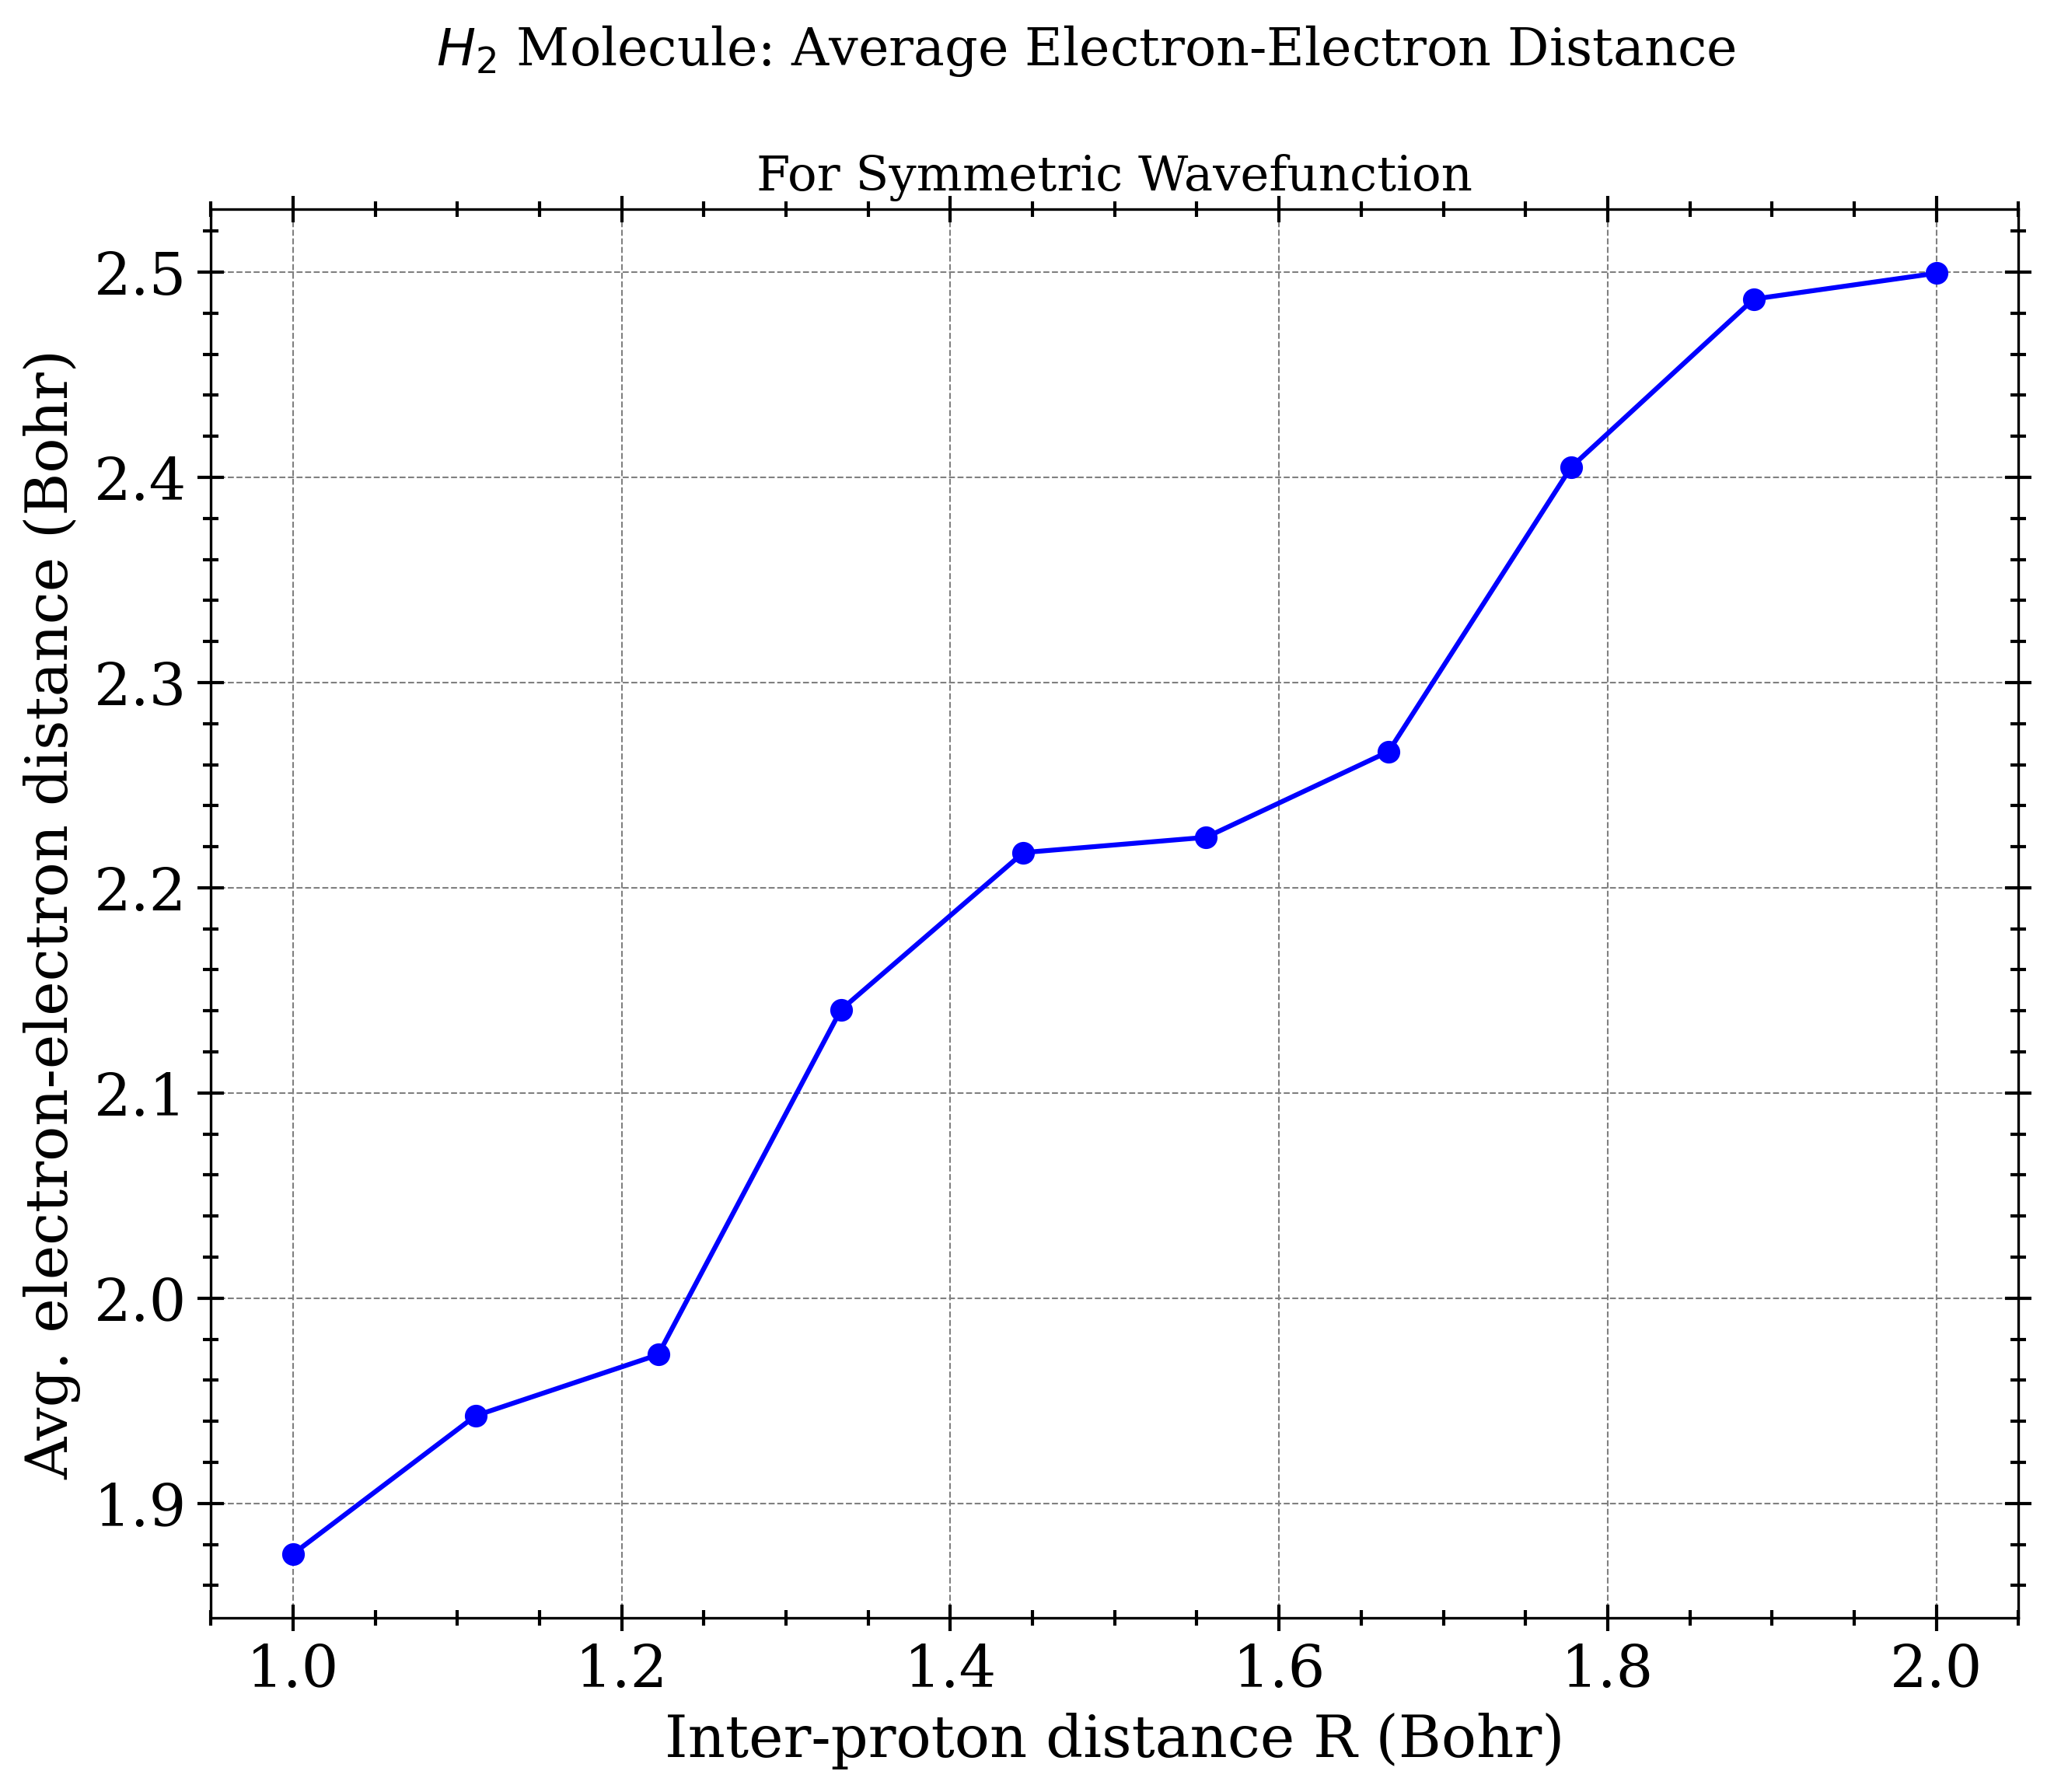

In [10]:
# plottting the results
plt.figure(figsize=(10,8))
plt.plot(R_s, r12_s, 'bo-')
plt.xlabel('Inter-proton distance R (Bohr)')
plt.ylabel('Avg. electron-electron distance (Bohr)')
plt.suptitle(r'$H_2$ Molecule Average Electron-Electron Distance', fontsize=16)
plt.title('For Symmetric Wavefunction', fontsize=15)
plt.show()

In [14]:
# making the dataframe contaning the mean energy and varivance for each value of alpha
df_2 = pd.DataFrame({r' Inter-proton distance R ': R_s, r'Mean distance $<r_{12}>$': r12_s})

print('symmetric')
df_2

symmetric


,Inter-proton distance R,Mean distance $<r_{12}>$
0,1.000000,1.875386
1,1.111111,1.942711
2,1.222222,1.972466
3,1.333333,2.140473
4,1.444444,2.217157
5,1.555556,2.224586
6,1.666667,2.266371
7,1.777778,2.404978
8,1.888889,2.486877
9,2.000000,2.499472


In [13]:
# Convert DataFrame to LaTeX table string
latex_table_2 = df_2.to_latex(
    index=False,           # Exclude index column
    header=True,           # Include column headers
    float_format="%.6f",   # Format float values
    caption="Sample Table", # Add caption
    label="tab:sample_table", # Add label for referencing
    column_format="lcc"    # Align columns (left, center, center)
)

# Print the LaTeX table string
print(latex_table_2)

\begin{table}
\centering
\caption{Sample Table}
\label{tab:sample_table}
\begin{tabular}{lcc}
\toprule
  Inter-proton distance R  &  Mean distance \$<r\_\{12\}>\$ \\
\midrule
                  1.000000 &                  1.875386 \\
                  1.111111 &                  1.942711 \\
                  1.222222 &                  1.972466 \\
                  1.333333 &                  2.140473 \\
                  1.444444 &                  2.217157 \\
                  1.555556 &                  2.224586 \\
                  1.666667 &                  2.266371 \\
                  1.777778 &                  2.404978 \\
                  1.888889 &                  2.486877 \\
                  2.000000 &                  2.499472 \\
\bottomrule
\end{tabular}
\end{table}

